In this notebook, I try the following experiment: Use extracted features from a certain layer of a pre-trained network as inputs into vae. That is, we take the extracted features as $x$ in vae. 

In the generating procedure, I generate features from vae. The I reconstruct image from generated features use methods in [1].

The results are bad, but I don't know why it is bad. One possible reason is that we also need to train the neural network according to the underlying generating distribution. (Below I tried to reconstruct an image using features extracted from an image generated by fc_vae.py but get unsatisfactory results.) On the other hand, the most possible reason is that I didn't choose the best set of parameters.


[1] Aravindh Mahendran, Andrea Vedaldi, "Understanding Deep Image Representations by Inverting them", CVPR 2015.


In [1]:
import sys
sys.path.append('../core/')
sys.path.append('../networks/')
from simple_fc import Encoder, Decoder
from vae_feats import Variational_Autoencoder

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

# As usual, a bit of setup

import time, os, json
import numpy as np
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt

from cs294_129.classifiers.pretrained_cnn import PretrainedCNN
from cs294_129.data_utils import load_tiny_imagenet
from cs294_129.image_utils import blur_image, deprocess_image, preprocess_image

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
sess = tf.InteractiveSession()
build_encoder = Encoder(100)
build_decoder = Decoder(100)
model = Variational_Autoencoder(sess, build_encoder, build_decoder, batch_size = 100, dataset = 'mnist',
                              learning_rate = 0.001, num_epochs = 2)
model.train()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Batch 1 loss: 13293.5546875
Batch 2 loss: 12376.9423828
Batch 3 loss: 11608.3466797
Batch 4 loss: 10994.4179688
Batch 5 loss: 10487.7402344
Batch 6 loss: 10027.9775391
Batch 7 loss: 9595.32421875
Batch 8 loss: 9187.63574219
Batch 9 loss: 8774.28613281
Batch 10 loss: 8355.32421875
Batch 11 loss: 7911.78613281
Batch 12 loss: 7478.20361328
Batch 13 loss: 7005.86132812
Batch 14 loss: 6519.69140625
Batch 15 loss: 6006.80810547
Batch 16 loss: 5471.99072266
Batch 17 loss: 4953.68212891
Batch 18 loss: 4435.59423828
Batch 19 loss: 3948.33569336
Batch 20 loss: 3491.00805664
Batch 21 loss: 3080.85058594
Batch 22 loss: 2725.08178711
Batch 23 loss: 2414.56958008
Batch 24 loss: 2150.14379883
Batch 25 loss: 1921.8260498
Batch 26 loss: 1728.5480957
Batch 27 loss: 1567.2734375
Batch 28 loss: 1431.59716797
Batch 

Exception AssertionError: AssertionError("Nesting violated for default stack of <type 'weakref'> objects",) in <bound method InteractiveSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x7f7aeb0eb710>> ignored


In [26]:
pre_trained_model = PretrainedCNN(h5_file='../networks/cs294_129/datasets/pretrained_model.h5')

In [13]:
mean_img = model.mean_img
def invert_features(target_feats, layer, model, **kwargs):
  """
  Perform feature inversion in the style of Mahendran and Vedaldi 2015, using
  L2 regularization and periodic blurring.
  
  Inputs:
  - target_feats: Image features of the target image, of shape (1, C, H, W);
    we will try to generate an image that matches these features
  - layer: The index of the layer from which the features were extracted
  - model: A PretrainedCNN that was used to extract features
  
  Keyword arguments:
  - learning_rate: The learning rate to use for gradient descent
  - num_iterations: The number of iterations to use for gradient descent
  - l2_reg: The strength of L2 regularization to use; this is lambda in the
    equation above.
  - blur_every: How often to blur the image as implicit regularization; set
    to 0 to disable blurring.
  - show_every: How often to show the generated image; set to 0 to disable
    showing intermediate reuslts.
    
  Returns:
  - X: Generated image of shape (1, 3, 64, 64) that matches the target features.
  """
  learning_rate = kwargs.pop('learning_rate', 10000)
  num_iterations = kwargs.pop('num_iterations', 500)
  l2_reg = kwargs.pop('l2_reg', 1e-7)
  blur_every = kwargs.pop('blur_every', 1)
  show_every = kwargs.pop('show_every', 50)
  
  X = np.random.randn(1, 3, 64, 64)
  for t in xrange(num_iterations):
    ############################################################################
    # TODO: Compute the image gradient dX of the reconstruction loss with      #
    # respect to the image. You should include L2 regularization penalizing    #
    # large pixel values in the generated image using the l2_reg parameter;    #
    # then update the generated image using the learning_rate from above.      #
    ############################################################################
    feats_X,cache = model.forward(X,end = layer)
    dout = 2 * (feats_X - target_feats) 
    dX,grads = model.backward(dout,cache) 
    dX += 2 * l2_reg * X 
    X -= learning_rate * dX
#     if t % 100 == 0:
#         loss = np.sum((feats_X - target_feats) ** 2) + l2_reg * np.sum(X ** 2)
#         print 'iterations {}: loss {}.'.format(t,loss)
    ############################################################################
    #                             END OF YOUR CODE                             #
    ############################################################################
    
    # As a regularizer, clip the image
    X = np.clip(X, - mean_img, 255.0 - mean_img)
    
    # As a regularizer, periodically blur the image
    if (blur_every > 0) and t % blur_every == 0:
      X = blur_image(X)

    if (show_every > 0) and (t % show_every == 0 or t + 1 == num_iterations):
      plt.imshow(deprocess_image(X, mean_img))
      plt.gcf().set_size_inches(3, 3)
      plt.axis('off')
      plt.title('t = %d' % t)
      plt.show()

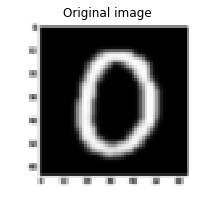

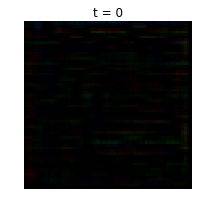

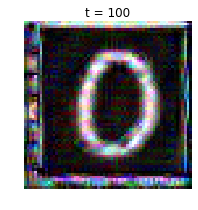

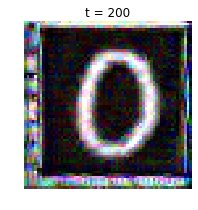

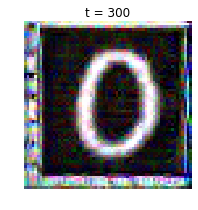

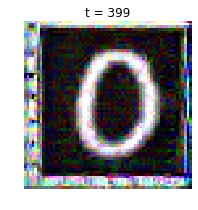

In [20]:
# Show that the extracted features from a real image (a hand written zero) can reconstruct the original zero.

import Image
Image.open('example.png').save('example.jpg','JPEG')
filename = 'example.jpg'
layer = 3 # layers start from 0 so these are features after 4 convolutions
img = imresize(imread(filename), (64, 64))
 
plt.imshow(img)
plt.gcf().set_size_inches(3, 3)
plt.title('Original image')
plt.axis('off')
plt.show() 
 
# img_pre = preprocess_image(img, readin_mean_img)
img_pre = preprocess_image(img, mean_img)

# Extract features from the image
feats, _ = pre_trained_model.forward(img_pre, end=layer)

# Add some noise to features.
feats += np.random.randn(*feats.shape) * 0.1  
# Invert the features
kwargs = {
  'num_iterations': 400,
  'learning_rate': 5000,
  'l2_reg': 1e-8,
  'show_every': 100,
  'blur_every': 10,
}
X = invert_features(feats, layer, pre_trained_model, **kwargs)

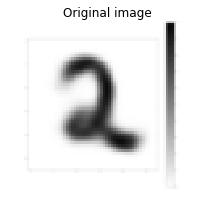

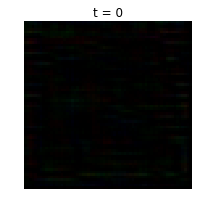

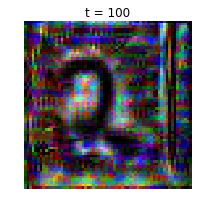

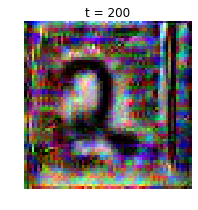

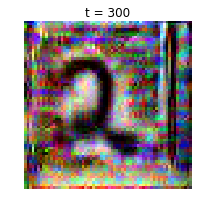

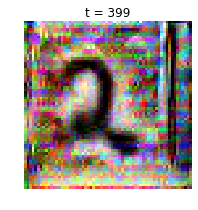

In [22]:
# Show extracted features from a generated image from our previous fc_vae.py cannot reconstruct the original image.

import Image
Image.open('example0.00295005029.png').save('example0.00295005029.jpg','JPEG')

filename = 'example0.00295005029.jpg'
layer = 3 # layers start from 0 so these are features after 4 convolutions
img = imresize(imread(filename), (64, 64))
 
plt.imshow(img)
plt.gcf().set_size_inches(3, 3)
plt.title('Original image')
plt.axis('off')
plt.show() 
 
# img_pre = preprocess_image(img, readin_mean_img)
img_pre = preprocess_image(img, mean_img)

# Extract features from the image
feats, _ = pre_trained_model.forward(img_pre, end=layer)

# Add some noise to features.
feats += np.random.randn(*feats.shape) * 0.1  
# Invert the features
kwargs = {
  'num_iterations': 400,
  'learning_rate': 5000,
  'l2_reg': 1e-8,
  'show_every': 100,
  'blur_every': 10,
}
X = invert_features(feats, layer, pre_trained_model, **kwargs)

In [5]:
model.save(2)

In [15]:
generated_feats = model.generate(1)


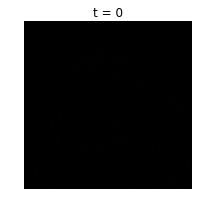

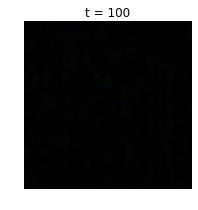

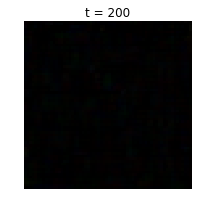

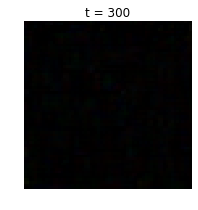

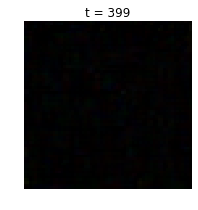

In [16]:
kwargs = {
  'num_iterations': 400,
  'learning_rate': 5000,
  'l2_reg': 1e-8,
  'show_every': 100,
  'blur_every': 10,
}
layer = 4
pre_trained_model = PretrainedCNN(h5_file='../networks/cs294_129/datasets/pretrained_model.h5') 
for i in range(1):
    X = invert_features(generated_feats[i].reshape(1,256,8,8), layer, pre_trained_model, **kwargs)
 

# As only inputting features yields bad performance, we try to input features combined with raw pixels.

In [2]:
import sys
sys.path.append('../core/')
sys.path.append('../networks/')
from simple_fc import Encoder, Decoder
from vae_combined import Variational_Autoencoder

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

# As usual, a bit of setup

import time, os, json
import numpy as np
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt

from cs294_129.classifiers.pretrained_cnn import PretrainedCNN
from cs294_129.data_utils import load_tiny_imagenet
from cs294_129.image_utils import blur_image, deprocess_image, preprocess_image

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
sess = tf.InteractiveSession()
build_encoder = Encoder(500)
build_decoder = Decoder(500) 
model = Variational_Autoencoder(sess, build_encoder, build_decoder, batch_size = 100, z_dim = 35, dataset = 'mnist',
                              learning_rate = 0.001, num_epochs = 2,layer = 9)
model.train()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
The input dimension is 1296.
Epoch 1 loss: 353.420162243
Epoch 2 loss: 305.168355103


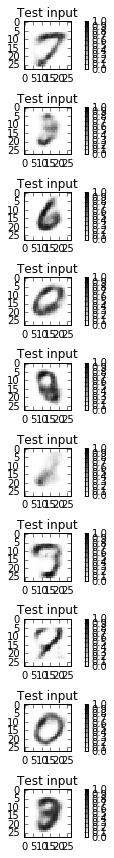

In [6]:
generated_images = model.generate(10)
plt.figure(figsize=(8, 12))
for i in range(10):
    plt.subplot(10, 2, 2*i + 1) 
    #plt.imshow(generated_images[i].reshape(28, 28), vmin=0, vmax=1) # color
    plt.imshow(generated_images[i].reshape(28, 28), cmap = 'gray_r', vmin=0, vmax=1) # grayscale
    plt.title("Test input")
    plt.colorbar()  
plt.tight_layout()